# FB Prophet model

Source: https://facebook.github.io/prophet/

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [27]:
path = '../data/'
data = pd.read_csv(path + 'Historical_Wildfire_fill0_new.csv')

In [31]:
data.tail()

,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Region
40733,2021-01-04,112.794545,330.534545,200.120000,96.381818,WA
40734,2021-01-05,34.222222,348.927778,391.577778,96.500000,WA
40735,2021-01-06,26.248000,324.645000,157.330000,91.700000,WA
40736,2021-01-07,17.887500,355.362500,303.066667,95.416667,WA
40737,2021-01-08,5.440000,327.200000,154.100000,82.000000,WA


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


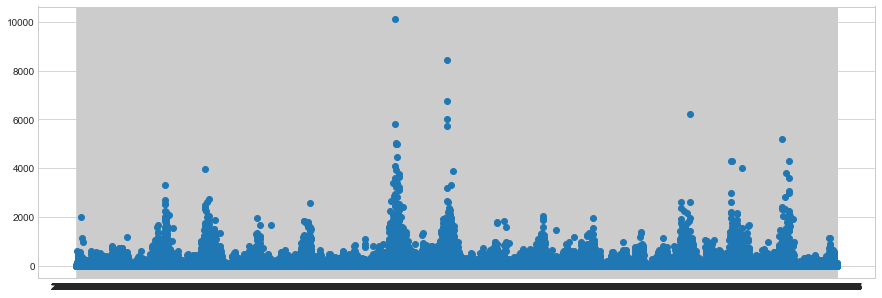

In [33]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.scatter(data['Date'], data['Estimated_fire_area'])
plt.show()

In [97]:
def prepare(data, region = 'NSW', start_date = '2005-01-01', end_date = '2022-01-01', test_size = 0.2):
    data = data.copy()
    
    # filter
    data = data[(start_date <= data['Date']) & (data['Date'] < end_date)]
    data = data[data['Region'] == region]
    
    # format
    col_map = {
        'Date': 'date',
        'Estimated_fire_area': 'fire',
    }
    data = data[['Date', 'Estimated_fire_area']].rename(columns = col_map)
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index)
    
    # convert to log
#     data = data[data['fire'] != 0]
    data['fire'] = np.log(data['fire']).clip(0)
    
    # split train / test
    train, test = train_test_split(data, test_size = test_size, shuffle = False)
    
    return train, test

In [98]:
train, test = prepare(data, region = 'NSW')

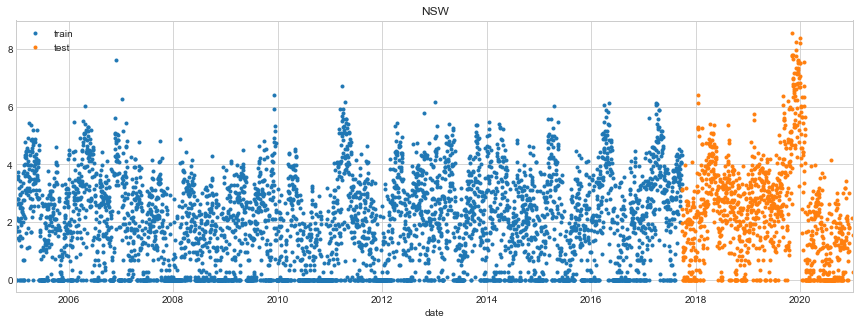

In [99]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title('NSW')
train.plot(y = 'fire', style = '.', ax = ax, label = 'train')
test.plot(y = 'fire', style = '.', ax = ax, label = 'test')
plt.show()

In [100]:
def convert(ts):
    col_map = {
        'date': 'ds',
        'fire': 'y',
    }
    ts = ts.copy().reset_index().rename(columns = col_map)
    return ts
    
def get_model(train, test):
    m = Prophet()
    m.fit(train)
    
    scores = {
        'rmse': [],
        'mae': [],
        'mape': [],
    }
    for df in [train, test]:
        forcast = m.predict(df)
        y_true = np.exp(df['y'])
        y_pred = np.exp(forcast['yhat'])
        scores['rmse'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        scores['mae'].append(mean_absolute_error(y_true, y_pred))
        scores['mape'].append(mean_absolute_percentage_error(y_true, y_pred))
    
    return m, m.predict(test), pd.DataFrame(scores, index = ['train', 'test'])

In [101]:
train, test = convert(train), convert(test)
model, forcast, scores = get_model(train, test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [102]:
scores

,rmse,mae,mape
train,54.180614,18.866824,1.858990
test,372.885557,89.408178,4.294649


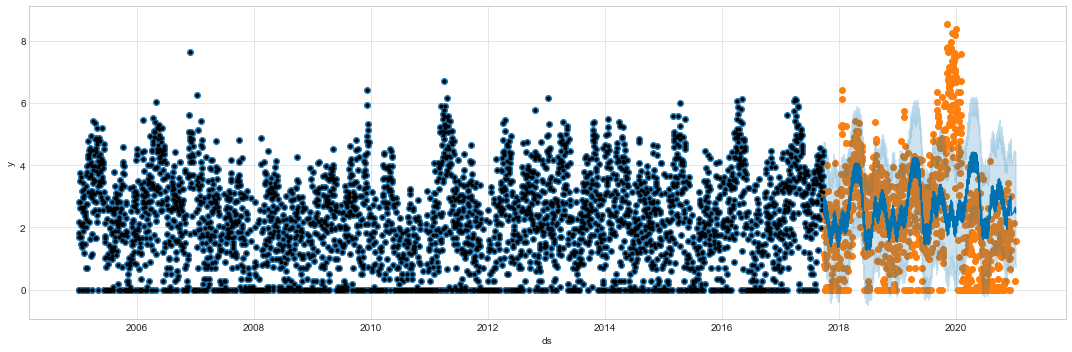

In [103]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.scatter(train['ds'], train['y'], label = 'train')
ax.scatter(test['ds'], test['y'], label = 'test')
model.plot(forcast, ax = ax)
plt.show()

In [104]:
def predict_range(data, start_date = '2021-02-01', end_date = '2021-03-01', show_plot = False):
    data = data.copy()
    regions = set(data['Region'])
    
    scores = []
    for region in regions:
        print(f'Predicting {region}...')
        
        train, test = prepare(data, region = region)
        
        train, test = convert(train), convert(test)
        
        if show_plot:
            # show data
            fig, ax = plt.subplots(figsize = (15, 5))
            plt.title(region)
            ax.scatter(train['ds'], train['y'], label = 'train')
            ax.scatter(test['ds'], test['y'], label = 'test')
            plt.show()
        
        model, forcast, s = get_model(train, test)
        
        if show_plot:
            # show fitted model
            fig, ax = plt.subplots(figsize = (15, 5))
            plt.title(f'{region} prediction')
            ax.scatter(train['ds'], train['y'], label = 'train')
            ax.scatter(test['ds'], test['y'], label = 'test')
            model.plot(forcast, ax = ax)
            plt.show()
        
        s['region'] = region
        scores.append(s)
    scores = pd.concat(scores)
    
    return scores

Predicting TA...


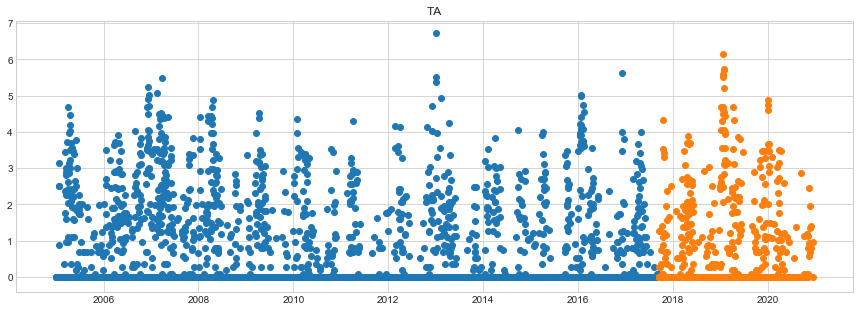

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


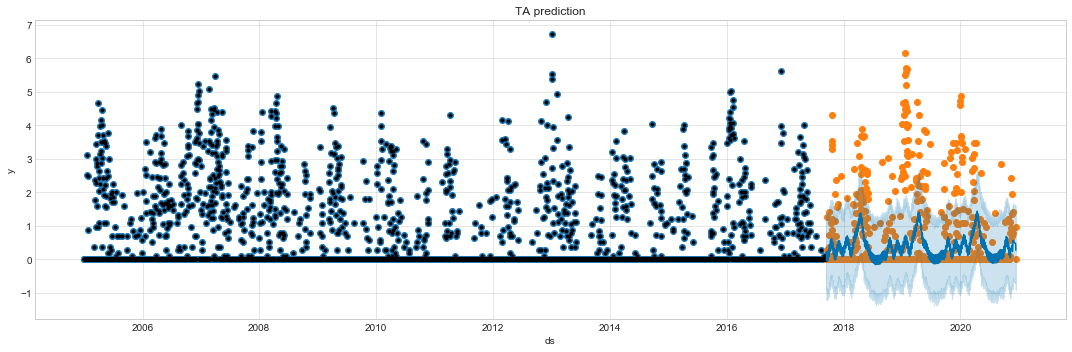

Predicting NT...


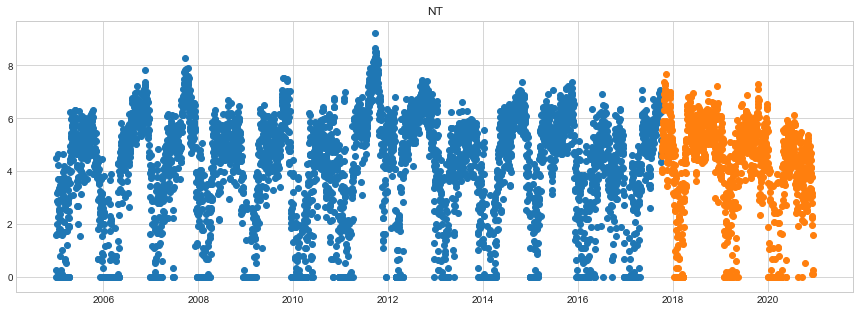

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


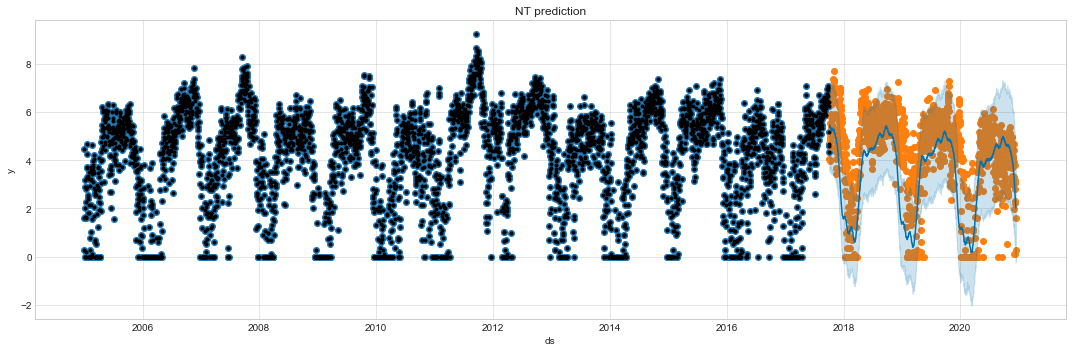

Predicting QL...


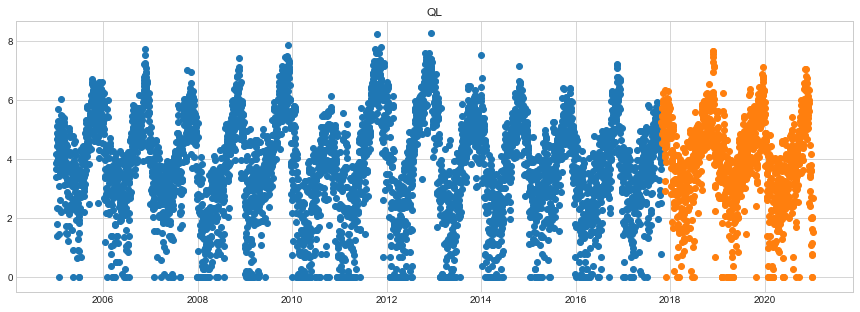

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


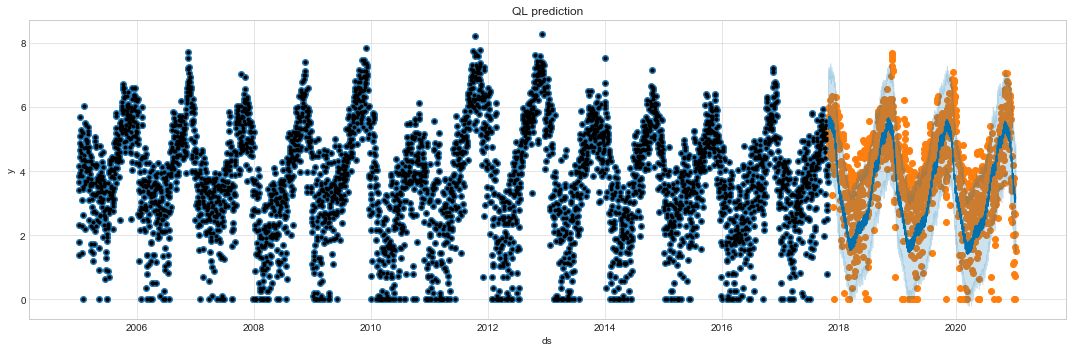

Predicting SA...


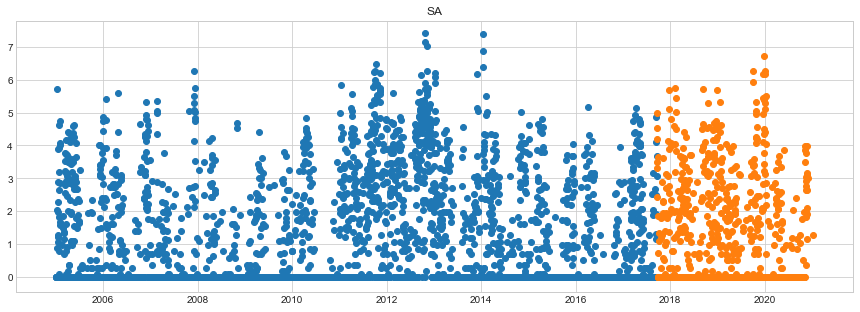

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


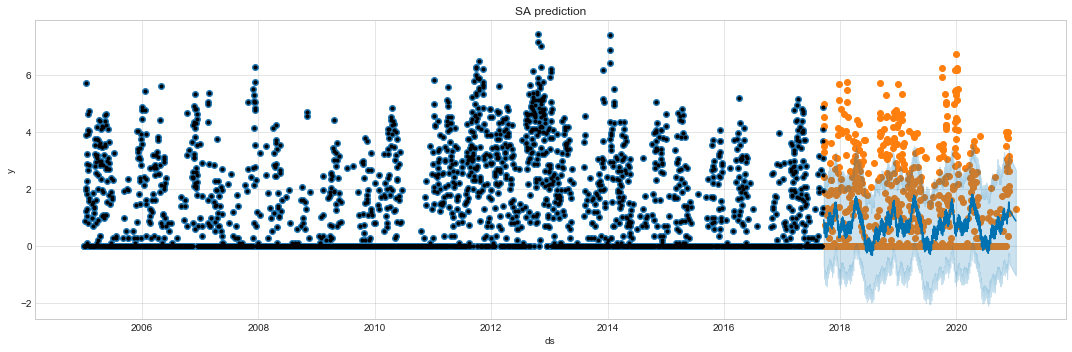

Predicting VI...


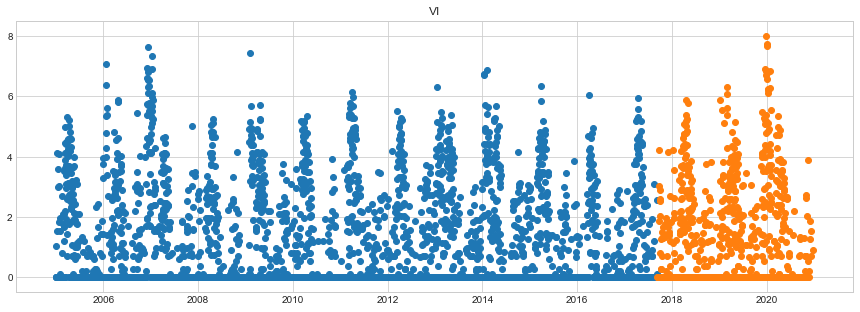

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


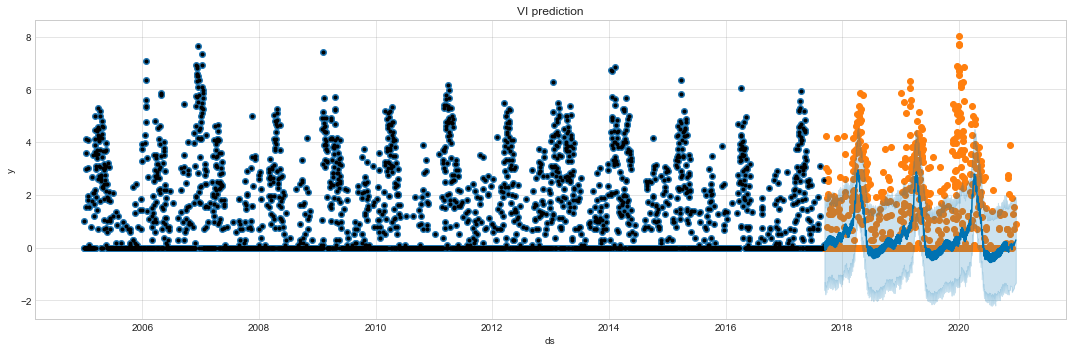

Predicting WA...


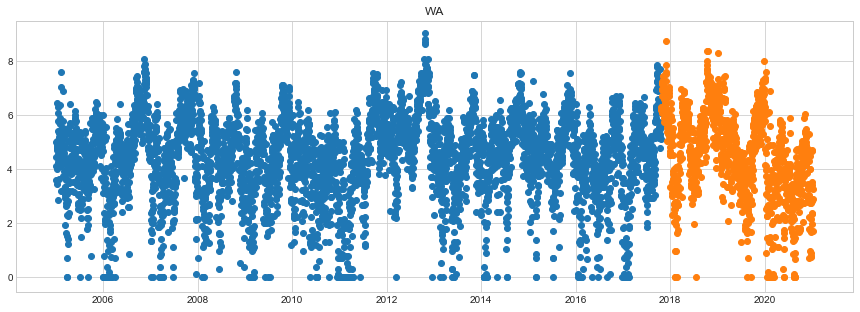

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


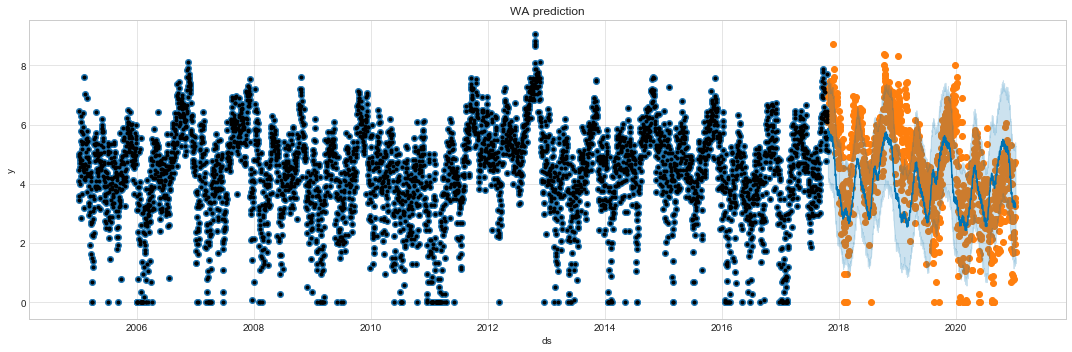

Predicting NSW...


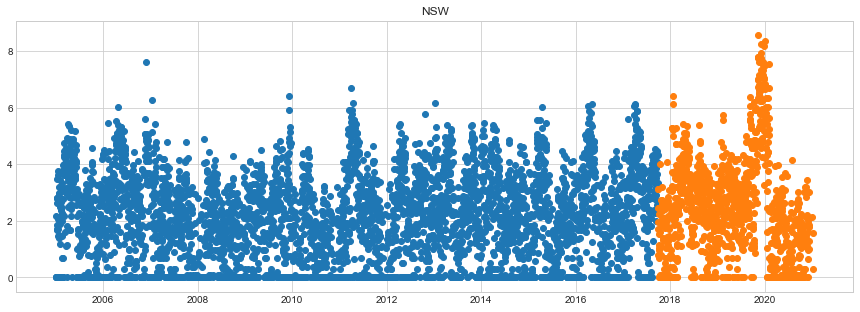

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


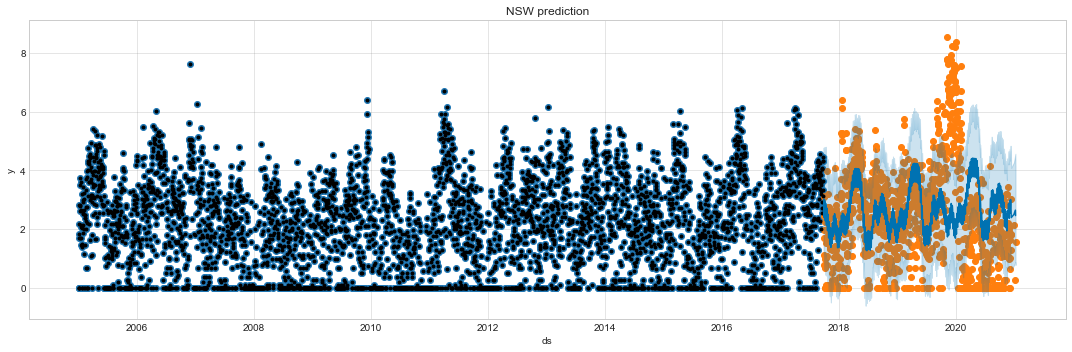

In [105]:
scores = predict_range(data, show_plot = True)

In [106]:
scores

,rmse,mae,mape,region
train,18.191213,3.421892,0.550879,TA
test,25.234384,4.704451,0.553045,TA
train,368.429409,152.947239,2.952833,NT
test,230.910387,125.682833,1.540929,NT
train,226.260905,92.959123,2.187803,QL
test,181.105836,81.257595,1.712700,QL
train,60.864632,12.738936,1.111105,SA
test,51.736524,12.840777,0.998204,SA
train,76.112932,14.714530,1.144081,VI
test,150.636318,23.980610,0.773092,VI
